In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

#### Reading in Data

In [75]:
df_jan = pd.read_parquet('fhv_tripdata_2021-01.parquet')
df_feb = pd.read_parquet('fhv_tripdata_2021-02.parquet')

#### Number of records for january

In [76]:
#number of records for january
print(f"Number of records in january {df_jan.shape[0]}")

Number of records in january 1154112


In [77]:
df_jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [78]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


#### Calculate Duration in January

In [79]:
#computes the duration of rides in minutes
def compute_duration(df):
    #computing duration in minutes
    df['duration'] = (df['dropOff_datetime'] - df['pickup_datetime']).dt.seconds/(60)
    return df

In [80]:
#calculate the duration of the trip
df_jan = compute_duration(df_jan)
df_feb = compute_duration(df_feb)

In [81]:
#average trip duration in January
print(f"Average trip duration in january: {df_jan['duration'].mean()}")

Average trip duration in january: 18.61074430673394


#### Data Preparation

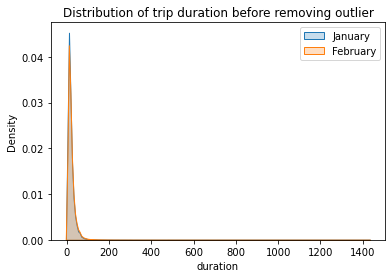

In [87]:
sns.kdeplot(df_jan['duration'], shade=True, label='January')
sns.kdeplot(df_feb['duration'], shade=True, label='February')
plt.title('Distribution of trip duration before removing outlier')
plt.legend(loc='upper right');

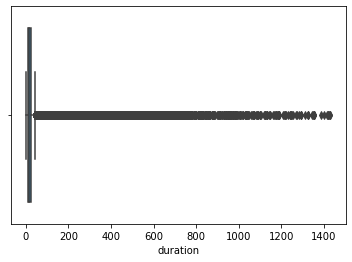

In [83]:
#boxplot for the duration of the trip in January
sns.boxplot(x='duration', data=df_jan);

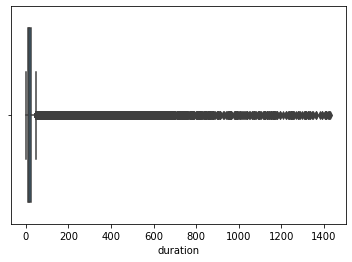

In [84]:
#boxplot for the duration of the trip in February
sns.boxplot(x='duration', data=df_feb);

In [85]:
#removing outliers (keeping duration between 1 and 60 minutes)
df_jan_clean = df_jan[df_jan['duration'].between(1, 60, inclusive='both')]
df_feb_clean = df_feb[df_feb['duration'].between(1, 60, inclusive='both')]

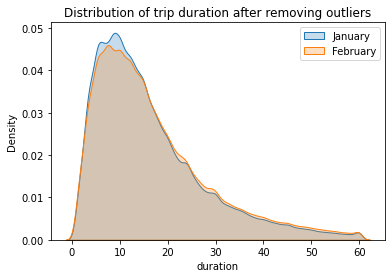

In [88]:
#kdeplot after removing outliers
sns.kdeplot(df_jan_clean['duration'], shade=True, label='January')
sns.kdeplot(df_feb_clean['duration'], shade=True, label='February')
plt.title('Distribution of trip duration after removing outliers')
plt.legend(loc='upper right');

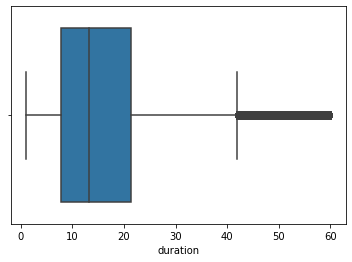

In [89]:
#boxplot for january after removing outliers
sns.boxplot(x='duration', data=df_jan_clean);

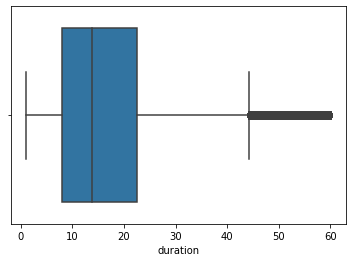

In [90]:
#boxplot for february after removing outliers
sns.boxplot(x='duration', data=df_feb_clean);

In [67]:
print(f"Number of records dropped in january: {df_jan.shape[0] - df_jan_clean.shape[0]}")
print(f"Number of records dropped in february: {df_feb.shape[0] - df_feb_clean.shape[0]}")

Number of records dropped in january: 44259
Number of records dropped in february: 47551


#### Missing Values

In [70]:
#checking missing values for january
df_jan_clean.isna().sum()

dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID               927033
DOlocationID               147927
SR_Flag                   1109853
Affiliated_base_number        773
duration                        0
dtype: int64

In [71]:
#checkign missing values for february
df_feb_clean.isna().sum()

dispatching_base_num           0
pickup_datetime                0
dropOff_datetime               0
PUlocationID              848679
DOlocationID              134774
SR_Flag                   990141
Affiliated_base_number         0
duration                       0
dtype: int64

In [91]:
#replace missing values with '-1'
df_jan_clean = df_jan_clean.fillna(-1).copy()
df_feb_clean = df_feb_clean.fillna(-1).copy()

In [94]:
df_jan_clean.isna().sum()

dispatching_base_num      0
pickup_datetime           0
dropOff_datetime          0
PUlocationID              0
DOlocationID              0
SR_Flag                   0
Affiliated_base_number    0
duration                  0
dtype: int64

In [95]:
df_feb_clean.isna().sum()

dispatching_base_num      0
pickup_datetime           0
dropOff_datetime          0
PUlocationID              0
DOlocationID              0
SR_Flag                   0
Affiliated_base_number    0
duration                  0
dtype: int64

In [105]:
#fraction of missing values for pickup location ID
(df_jan_clean['PUlocationID']==-1).sum()/(df_jan_clean['PUlocationID'].shape[0])

0.835275482428754

#### One-Hot Encoding

In [109]:
#selecting the pickup location ID and dropoff location ID as features
categorical_features = ['PUlocationID', 'DOlocationID']

In [110]:
df_jan_clean[categorical_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109853 entries, 0 to 1154111
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   PUlocationID  1109853 non-null  float64
 1   DOlocationID  1109853 non-null  float64
dtypes: float64(2)
memory usage: 25.4 MB


In [119]:
#converting pickup location ID and dropoff location ID data types to string from float
X_train_df = df_jan_clean[categorical_features].astype(str)
y_train = df_jan_clean['duration']
X_test_df = df_feb_clean[categorical_features].astype(str)
y_test = df_feb_clean['duration']

In [120]:
#turn dataframes to list of dictionaries
X_train_dict = X_train_df.to_dict(orient='records')
X_test_dict = X_test_df.to_dict(orient='records')

In [121]:
#fit a dictionary vectorizer
vec = DV()
X_train = vec.fit_transform(X_train_dict)

In [124]:
#getting the feature names
vec.feature_names_

['DOlocationID=-1.0',
 'DOlocationID=1.0',
 'DOlocationID=10.0',
 'DOlocationID=100.0',
 'DOlocationID=101.0',
 'DOlocationID=102.0',
 'DOlocationID=105.0',
 'DOlocationID=106.0',
 'DOlocationID=107.0',
 'DOlocationID=108.0',
 'DOlocationID=109.0',
 'DOlocationID=11.0',
 'DOlocationID=111.0',
 'DOlocationID=112.0',
 'DOlocationID=113.0',
 'DOlocationID=114.0',
 'DOlocationID=115.0',
 'DOlocationID=116.0',
 'DOlocationID=117.0',
 'DOlocationID=118.0',
 'DOlocationID=119.0',
 'DOlocationID=12.0',
 'DOlocationID=120.0',
 'DOlocationID=121.0',
 'DOlocationID=122.0',
 'DOlocationID=123.0',
 'DOlocationID=124.0',
 'DOlocationID=125.0',
 'DOlocationID=126.0',
 'DOlocationID=127.0',
 'DOlocationID=128.0',
 'DOlocationID=129.0',
 'DOlocationID=13.0',
 'DOlocationID=130.0',
 'DOlocationID=131.0',
 'DOlocationID=132.0',
 'DOlocationID=133.0',
 'DOlocationID=134.0',
 'DOlocationID=135.0',
 'DOlocationID=136.0',
 'DOlocationID=137.0',
 'DOlocationID=138.0',
 'DOlocationID=139.0',
 'DOlocationID=14.

In [126]:
X_train

<1109853x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219706 stored elements in Compressed Sparse Row format>

- So `X_train` is 1109835 x 525 matrix
- So it's dimensionality os **525**

#### Modeling

In [127]:
##fit a linear regression model
reg = LR()
reg.fit(X_train, y_train)

LinearRegression()

In [128]:
#rmse on the training set
mse(y_train, reg.predict(X_train), squared=False)

10.528643549679181

In [131]:
#evaluate the model on the test set
#creating test set from X_test_dict
X_test = vec.transform(X_test_dict)
#calculating rmse on the test set
mse(y_test, reg.predict(X_test), squared=False)

11.014592273737696